In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from scipy.stats import ttest_ind
%matplotlib inline
from IPython.display import Image
from IPython.core.display import HTML 

# BUYING A USED CAR IN GERMANY
May 2018 by Inna Wendell 

The purpose of this project was to analyze different factors that may effect used car prices in Germany. This analysis was performed using a dataset which was uploaded to *kaggle.com* by Orges Leka. The dataset is accessible under the url: https://www.kaggle.com/orgesleka/used-cars-database. Orges Leka scraped over 371,713 used car listings from German *Ebay* Classified Ads. The content of the data is in German. 

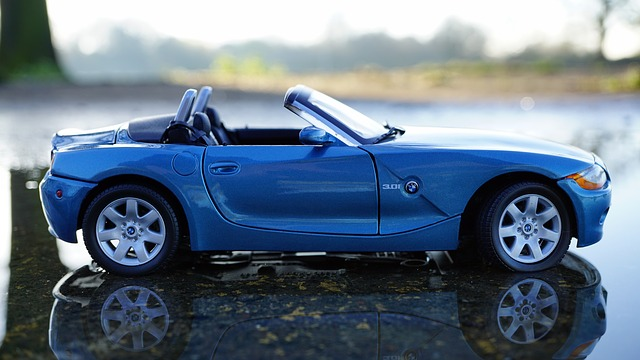

In [2]:
path = 'C:\Inna\'s files\data\Cars\car.jpg'
Image(filename = path, width=600, height=300)

Each row in the dataset represents an ad listing. Columns include: 
 - dateCrawled : when this ad was first crawled, all field-values are taken from this date
 - name : "name" of the car
 - seller : private or dealer
 - offerType
 - price : the price on the ad to sell the car
 - abtest
 - vehicleType
 - yearOfRegistration : at which year the car was first registered
 - gearbox
 - powerPS : power of the car in PS
 - model
 - kilometer : how many kilometers the car has driven
 - monthOfRegistration : at which month the car was first registered
 - fuelType
 - brand
 - notRepairedDamage : if the car has a damage which is not repaired yet
 - dateCreated : the date for which the ad at ebay was created
 - nrOfPictures : number of pictures in the ad (unfortunately this field contains everywhere a 0 and is thus useless (bug in crawler!) )
 - postalCode
 - lastSeenOnline : when the crawler saw this ad last online

Since the dataset is rather large, this analysis will only focus on select features.

In [3]:
#Import the raw data
cars = pd.read_csv('C:\Inna\'s files\data\Cars\cars.csv', encoding='ISO-8859-1')
cars.columns

Index(['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest',
       'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model',
       'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode',
       'lastSeen'],
      dtype='object')

In [4]:
cars.columns

Index(['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest',
       'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model',
       'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode',
       'lastSeen'],
      dtype='object')

In [5]:
#Change the data type of the columns
cars['dateCreated'] = pd.to_datetime(cars['dateCreated'], format = '%m/%d/%Y %H:%M')
cars['lastSeen'] = pd.to_datetime(cars['lastSeen'], format = '%m/%d/%Y %H:%M')
cars['price'] = pd.to_numeric(cars['price'], errors='coerce')
cars = cars.dropna(subset=['price'])                             
cars['price'] = cars['price'].astype(int)
cars['dateCrawled'] = pd.to_datetime(cars['dateCrawled'], format = '%m/%d/%Y %H:%M')

More columns have been added for faciliation of this analysis, including the number of days a car was listed on *Ebay* and mileage classifiers into low mileage (with less than 5,000 kilometers or approx. 3,106 miles) and higher mileage (over 5,000 kilometers).

In [6]:
#creation of a new column with the days listed
cars['days_listed'] = cars['lastSeen'] - cars['dateCreated']

#add two columns classifying mileage that become useful later
cars['lowest_km']=np.where (cars['kilometer'] <= 5000, 1,0)
cars['highest_km']=np.where (cars['kilometer'] > 5000, 1,0)

In [7]:
cars.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,...,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen,days_listed,lowest_km,highest_km
0,2016-03-24 11:52:00,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,...,benzin,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:00,14 days 03:16:00,0,1
1,2016-03-24 10:58:00,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,...,diesel,audi,ja,2016-03-24,0,66954,2016-04-07 01:46:00,14 days 01:46:00,0,1
2,2016-03-14 12:52:00,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,...,diesel,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:00,22 days 12:47:00,0,1
3,2016-03-17 16:54:00,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,...,benzin,volkswagen,nein,2016-03-17,0,91074,2016-03-17 17:40:00,0 days 17:40:00,0,1
4,2016-03-31 17:25:00,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,...,diesel,skoda,nein,2016-03-31,0,60437,2016-04-06 10:17:00,6 days 10:17:00,0,1


# DATA CLEANING

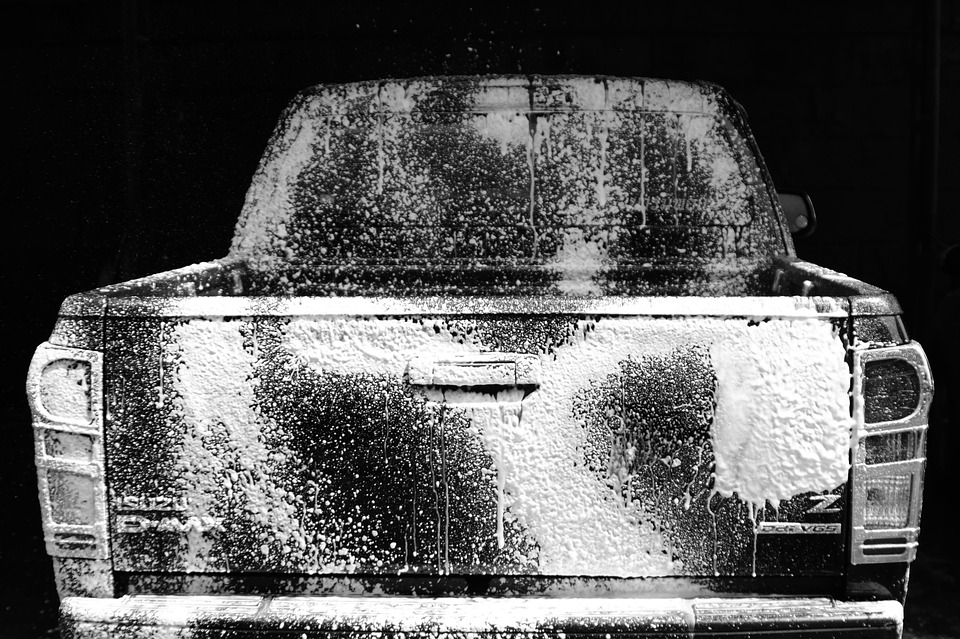

In [8]:
path_one = 'C:\Inna\'s files\data\Cars\cleaning.jpg'
Image(filename = path_one, width=500, height=100)

It is worth mentioning that the method of data collection (web crawling) had a bearing on the data quality. At first, it became necessary to clean the data. Some issues encountered included:  

 - Improper punctuation of original the csv file which resulted in jamming of 176 values in a single cell.
 -  Registration year values of 9999.
 -  Registration years of 2017 and 2018 which are problematic since the data last crawled was 04/07/2016. 
 - Since car ads listed also included approximately 2,000 values dated after April 2016 (time last crawled), this year was also exluded from the analysis as unreliable.
 - Car prices of less than €100 and over €1,000,000 were attributed to bugs in the crawler.


Additionally, the following choices were made for the purposes of this analysis:
 - We were only interested in cars for sale, not in cars 'wanted', so the latter were excluded from the dataset.
 - Only the cars with no reported unrepaired damage were included in this analysis. The limitation of our dataset is that we cannot be sure that this means that the car had not previosuly been in a wreck: the only thing we know is that the car does not currently have any reported damage. 

In [9]:
#Verify the data types of the columns
cars.dtypes

dateCrawled             datetime64[ns]
name                            object
seller                          object
offerType                       object
price                            int32
abtest                          object
vehicleType                     object
yearOfRegistration               int64
gearbox                         object
powerPS                          int64
model                           object
kilometer                        int64
monthOfRegistration              int64
fuelType                        object
brand                           object
notRepairedDamage               object
dateCreated             datetime64[ns]
nrOfPictures                     int64
postalCode                       int64
lastSeen                datetime64[ns]
days_listed            timedelta64[ns]
lowest_km                        int32
highest_km                       int32
dtype: object

In [10]:
cars['dateCrawled'].max()

Timestamp('2016-04-07 14:36:00')

In [11]:
#Remove cars 'wanted'
cars = cars.drop(cars[cars['offerType'] != 'Angebot'].index)

In [12]:
#Exclude the cars with not repaired damage
no_damage = cars.loc[lambda df: cars['notRepairedDamage'] == 'nein', :]

In [13]:
#removing suspicious year of registration values from the dataset
fixed_year = no_damage.loc[(no_damage['yearOfRegistration'] != 9999) &(no_damage['yearOfRegistration']> 1885) & (no_damage['yearOfRegistration']< 2016)]

In [14]:
#Some price values contained suspicious entries. We will limit our data to price over 100 to avoid dealing with not real prices.
fixed_prices = fixed_year.loc[(fixed_year['price'] >100) & (fixed_year['price'] < 1000000)]

# WHAT CAN WE FIND OUT?

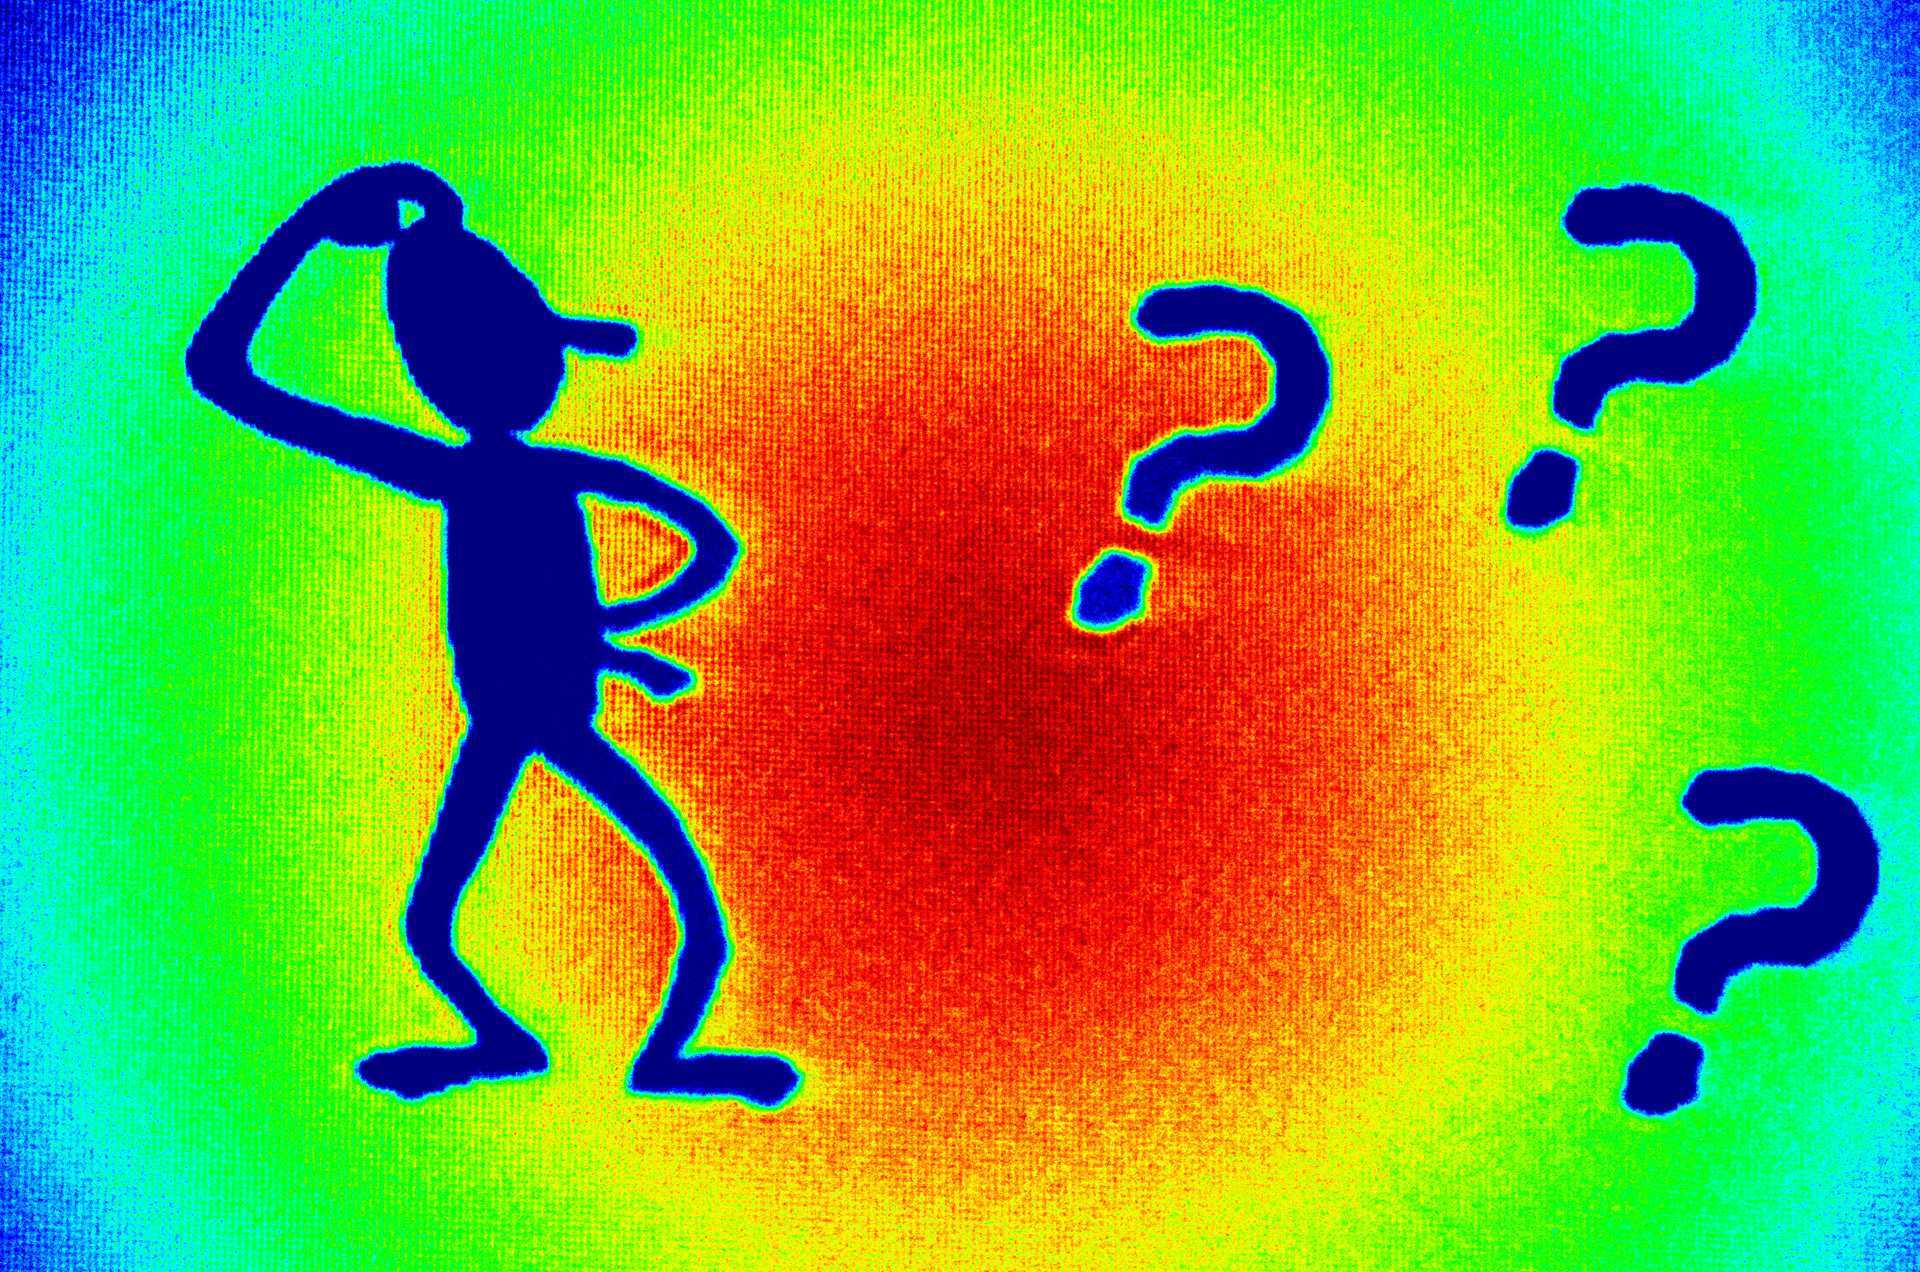

In [15]:
path_two = 'C:\Inna\'s files\data\Cars\questions.jpg'
Image(filename = path_two, width=500, height=100)

In [16]:
fixed_prices.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode,days_listed,lowest_km,highest_km
count,248482.000000,248482.000000,248482.000000,248482.000000,248482.000000,248482.0,248482.000000,248482,248482.000000,248482.000000
mean,7229.563224,2003.420095,126.772994,122748.790657,6.198034,0.0,51797.913897,9 days 20:17:37.730056,0.008717,0.991283
std,11324.554264,6.773940,161.512278,40460.251298,3.473837,0.0,25880.853051,8 days 16:36:26.561443,0.092957,0.092957
min,101.000000,1910.000000,0.000000,5000.000000,0.000000,0.0,1067.000000,0 days 00:36:00,0.000000,0.000000
25%,1850.000000,2000.000000,75.000000,100000.000000,3.000000,0.0,31224.000000,2 days 18:17:00,0.000000,1.000000
50%,4250.000000,2004.000000,116.000000,150000.000000,6.000000,0.0,51063.000000,7 days 04:45:00,0.000000,1.000000
75%,9100.000000,2008.000000,156.000000,150000.000000,9.000000,0.0,72770.000000,14 days 21:18:00,0.000000,1.000000
max,999999.000000,2015.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000,384 days 03:45:00,1.000000,1.000000


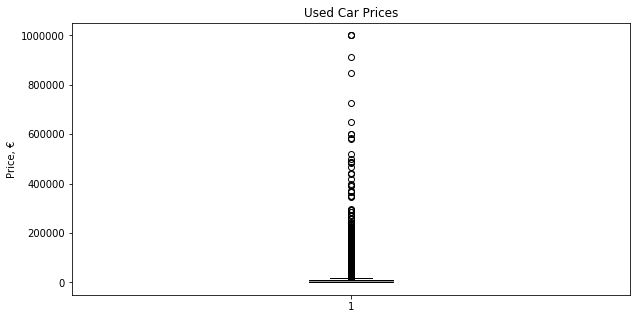

In [17]:
plt.figure(figsize=(10,5))
plt.boxplot(fixed_prices['price'])
plt.title('Used Car Prices')
plt.ylabel('Price, €')
plt.show()

The boxplot above shows us that our data has a lot of high outliers in respect to price. We will decide to approach this data set from the perspective of a potential used car buyer on a budget. What is a good deal? To answer this question, we will examine prices within two interquartile ranges of the median (€18,750 or $22,416.30) which we define as **AFFORDABLE**.

In [18]:
median = fixed_prices['price'].median()
IQR = 9100 - 1850
print(median + 2 * IQR)

18750.0


In [19]:
#cut off prices at €18,750
affordable = fixed_prices.loc[lambda df: fixed_prices['price'] < 18750, :]

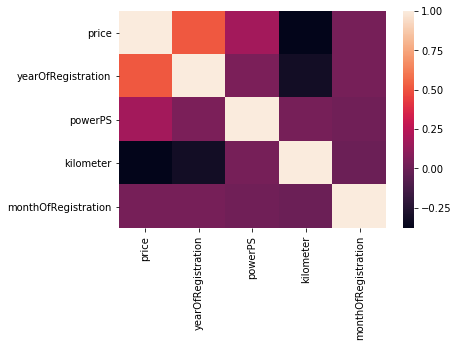

In [20]:
corr = affordable.drop(columns=['nrOfPictures', 'lowest_km', 'highest_km', 'postalCode']).corr()
sns.heatmap(corr)

The heatmap above gives us interesting insight into our data: there seems to be a positive correlation between the car price and year of registration and negative correlation between the price and mileage(kilometer). Let us further examine these relations. 

##  LOW MILEAGE = EXPENSIVE?

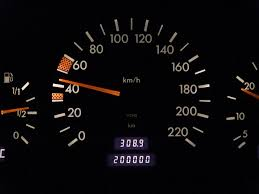

In [21]:
path_three = 'C:\Inna\'s files\data\Cars\mileage.jpg'
Image(filename = path_three, width=300, height=100)

## PRICE DISTRIBUTION FOR AFFORDABLE CARS

As buyers, we might be interested to find out if cars with lower mileage are necessarily going to be more expensive. To answer this question, we will first examine the price and kilometer distributions for the affordable cars (1 km = 0.62 mi).

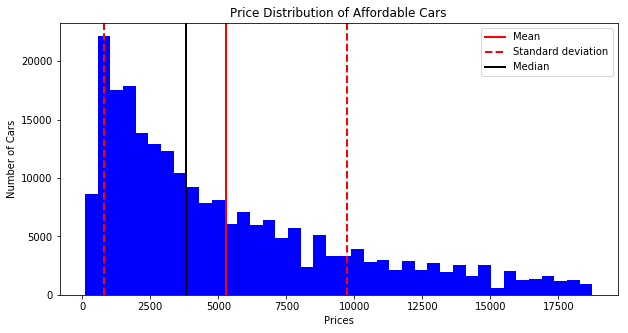

In [22]:
plt.figure(figsize=(10,5))

plt.hist(affordable['price'], color='b', bins = 40)
price_mean = plt.axvline(affordable['price'].mean(), color='r',linestyle='solid', linewidth=2); M1 = 'Mean';
price_std = plt.axvline(affordable['price'].mean() + affordable['price'].std(), color='r',linestyle='dashed', linewidth=2); M2 = 'Standard deviation';
plt.axvline(affordable['price'].mean() - affordable['price'].std(), color='r',linestyle='dashed', linewidth=2)
price_median = plt.axvline(np.median(affordable['price']), color='black',linestyle='solid', linewidth=2); M3='Median'

plt.title('Price Distribution of Affordable Cars')
plt.xlabel('Prices')
plt.ylabel('Number of Cars')
plt.legend([price_mean, price_std, price_median], [M1, M2, M3])
plt.show()


In [23]:
print ('Mean price:', np.mean(affordable['price']))
print ('Median price:', np.median(affordable['price']))
print ('Standard deviation:',affordable['price'].std() )

Mean price: 5263.964758879987
Median price: 3800.0
Standard deviation: 4460.479394740278


The distribution of the prices for affordable cars is **not normal**: it is skewed to the right. Standard deviation is high as there is a lot of variation in our data. The difference between the mean and median is significant, which tells us that the mean is most likely affected by high outliers. 

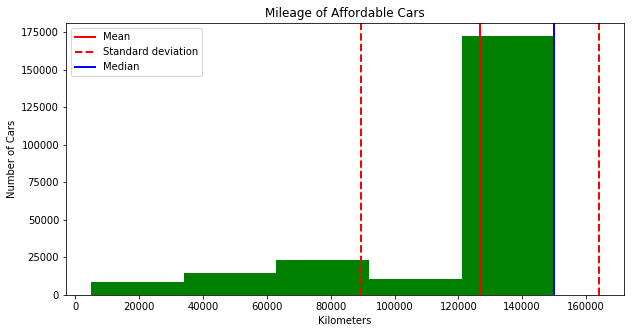

In [24]:
plt.figure(figsize=(10,5))
plt.hist(affordable['kilometer'], color='green', bins=5)

mean = plt.axvline((affordable['kilometer']).mean(), color='r',linestyle='solid', linewidth=2); M1= 'Mean';
std_one = plt.axvline((affordable['kilometer']).mean() + (affordable['kilometer']).std(), color='r',linestyle='dashed', linewidth=2); M2='Standard deviation';
std_two = plt.axvline((affordable['kilometer']).mean() - (affordable['kilometer']).std(), color='r',linestyle='dashed', linewidth=2); M3='Standard deviation';
median = plt.axvline(np.median(affordable['kilometer']), color='blue',linestyle='solid', linewidth=2); M4='Median';

plt.legend([mean, std_one, median], [M1, M2, M4])
plt.title('Mileage of Affordable Cars')
plt.xlabel('Kilometers')
plt.ylabel('Number of Cars')

plt.show()


In [25]:
print ('Mean mileage:', np.mean(affordable['kilometer']))
print ('Median mileage:', np.median(affordable['kilometer']))
print ('Standard deviation:',affordable['kilometer'].std() )

Mean mileage: 126721.03793354332
Median mileage: 150000.0
Standard deviation: 37279.93855466141


Mileage distribution for affordable cars also does not appear to be normal: it is left-skewed. Mean mileage is lower than median mileage which is a sign that the mean is affected by low outliers. Now that we know the distributions of the two variables, it becomes useful to examine them together. Additional analysis reveals that there is -0.38 correlation between price and kilometers: cars with more mileage overall seem to be cheaper.

In [26]:
affordable['price'].corr(affordable['kilometer'])

-0.3815168091660202

However, if we examine the mileage data more closely, we will notice that there is a whole group of cars with under 5,000 kilometers that are surprisingly lower in price. Despite the fact that this group is most likely compiled of low outliers, we as buyers, might be interested in going after the outliers because they could be an unusually good deal.

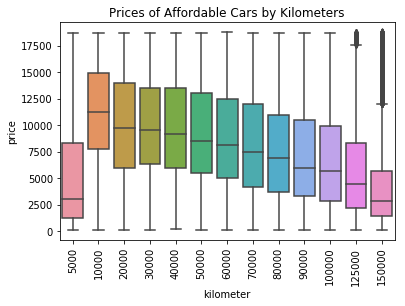

In [27]:
#Ideally, I would create a scatter plot, but 'kilometer' happened to be a discrete variable 

sns.boxplot(x="kilometer", y="price", data=affordable) 
plt.xticks(rotation=90);
plt.title('Prices of Affordable Cars by Kilometers')

plt.show()

In [28]:
low_mileage = affordable.loc[lambda df: affordable['lowest_km']==1, :]
high_mileage=affordable.loc[lambda df: affordable['highest_km']==1, :]


In [29]:
print(ttest_ind(high_mileage['price'], low_mileage['price'], equal_var=False))

Ttest_indResult(statistic=0.9307448066242158, pvalue=0.3521152612002497)


We can conduct an experiment and compare the two groups: prices for the cars with less than 5,000 kms and cars with over 5,000 and determine the difference between them in terms of price is statistically significant. Our t-test returns a very small p-value and we can, therefore, conclude that the difference in the prices between cars with under 5,000 km and cars with over 5,000 km is statistically significant.

##  OLD CAR = CHEAPER?

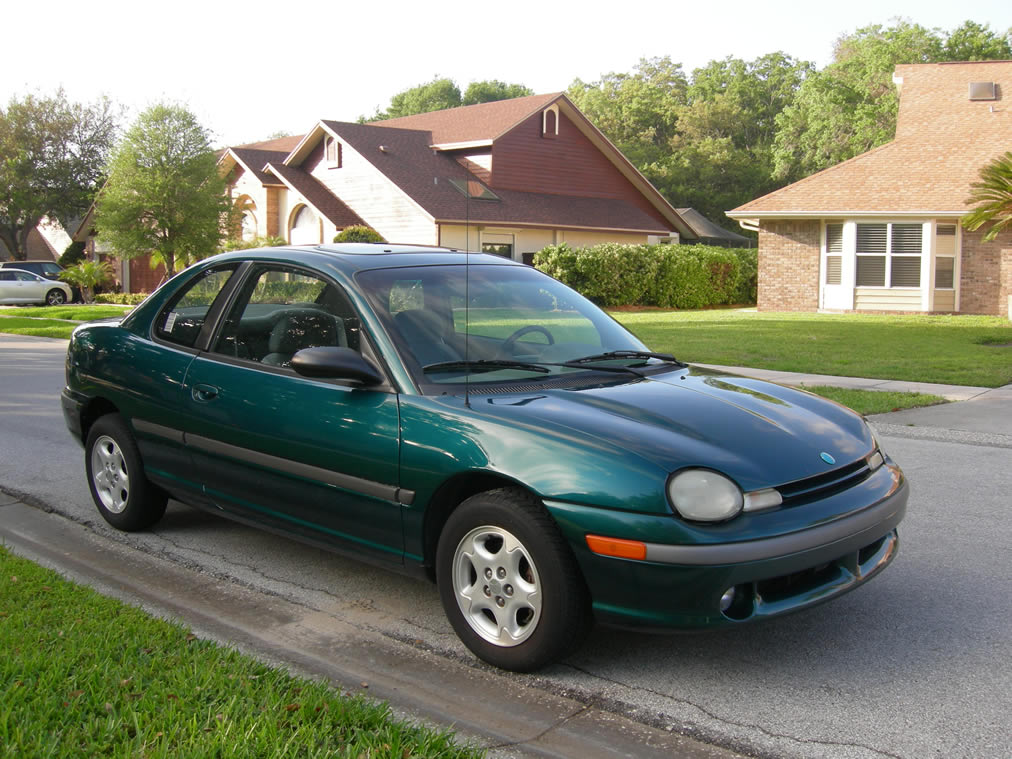

In [30]:
path_four = 'C:\Inna\'s files\data\Cars\old.jpg'
Image(filename = path_four, width=400, height=100)

Another question we could investigate is whether or not older cars are going to be more affordable. Overall, there seems to be a reasonably strong positive correlation between registration years and car prices (appr. 0.52). However, we shall examine our data more closely.

In [31]:
affordable['price'].corr(affordable['yearOfRegistration'])

0.5181585096630948

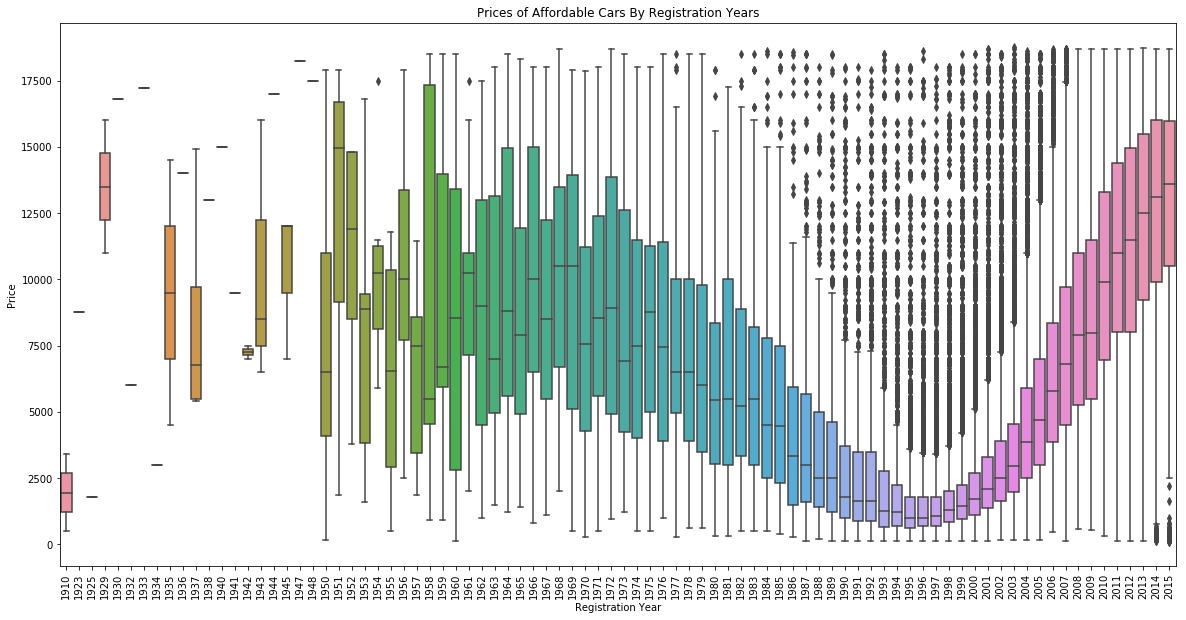

In [32]:
plt.figure(figsize=(20,10))
sns.boxplot(x="yearOfRegistration", y="price", data=affordable)
plt.title('Prices of Affordable Cars By Registration Years')
plt.ylabel('Price')
plt.xlabel('Registration Year')
plt.xticks(rotation=90)
plt.show()

The graph above presents an interesting picture. Not all old cars are the same. Some older cars, most likely, the collectibles, are also on the pricey side. It is interesting to compare cars registered earlier than 1983 and the cars registered between 1983 and 2006 (as this is the approximation of the dip in the graph) to see if these two groups of old cars are different.


In [33]:
old_cars = affordable.loc[lambda df: affordable.yearOfRegistration < 1983,:]
newer_cars = affordable.loc[(affordable.yearOfRegistration > 1983) & (affordable.yearOfRegistration < 2006)]

In [34]:
print(ttest_ind(old_cars['price'],newer_cars['price'], equal_var=False))

Ttest_indResult(statistic=50.85248984816775, pvalue=0.0)


The t-test returns the p-value of 0. The difference in prices of the cars registered earlier than 1983 and the cars registered between 1983 and 2006 is statistically significant. As we can clearly see from the graph above, cars from the latter group (1983-2006) are much cheaper. However, an interesting observation is that the cars (earlier than 1983) sell much slower (11 days on average) than cars from between 1983 and 2006 (9 days on average).

In [35]:
old_cars['days_listed'].mean()

Timedelta('11 days 15:07:26.380832')

In [36]:
newer_cars['days_listed'].mean()

Timedelta('9 days 01:47:37.393031')

In [37]:
print(ttest_ind(old_cars['days_listed'].dt.days,newer_cars['days_listed'].dt.days, equal_var=False))

Ttest_indResult(statistic=13.423394385949473, pvalue=1.083442512642484e-39)


Our t-test shows that the difference in the number of days listed between the two groups is significant (p-value is very small). Cars registered earlier than 1983 do sell **significantly slower **than cars registered between 1983 and 2006.

##   CAN WE GET A DEAL?

We already found out previously that it is possible to get an affordable car with less than 5,000 kms because why not go for the outliers? Now we could try to find out which registration years we should be looking for.

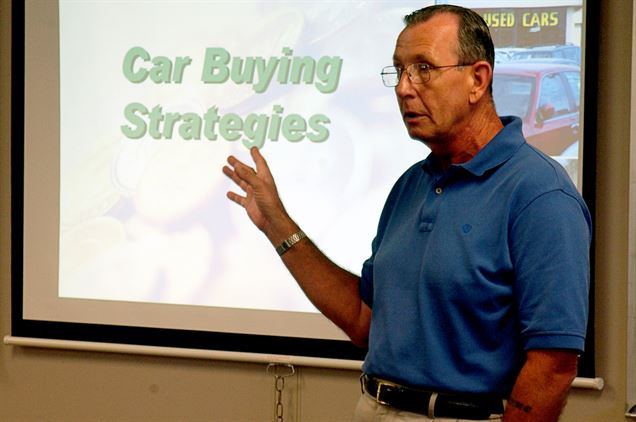

In [38]:
path_new = 'C:\Inna\'s files\data\Cars\strategies.jpg'
Image(filename = path_new, width=600, height=300)

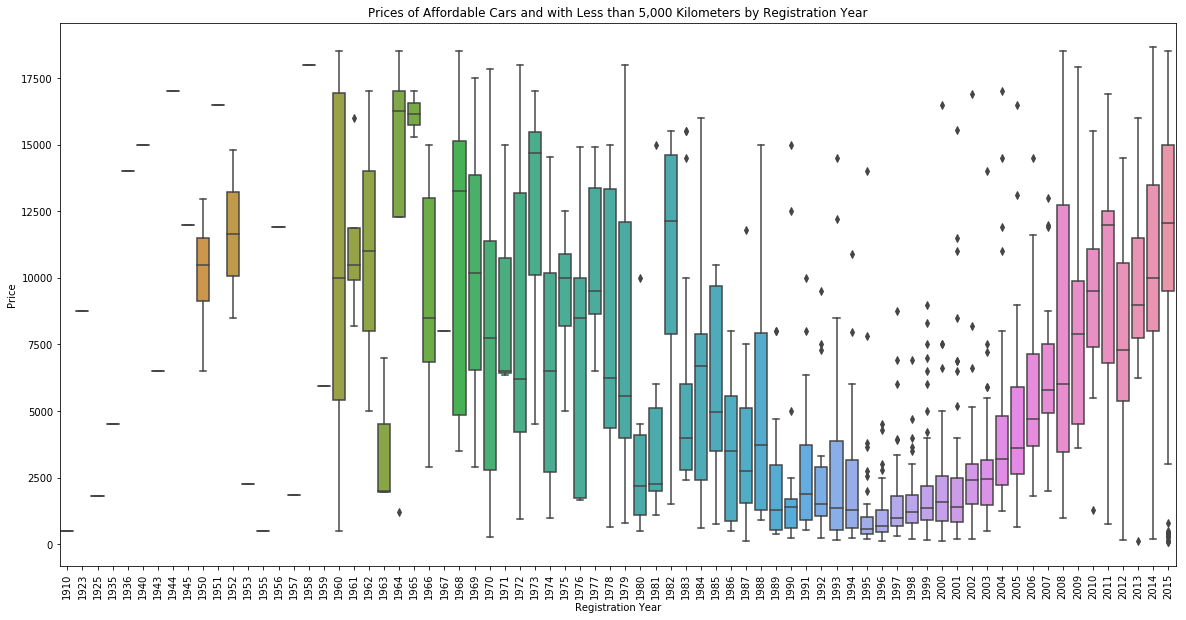

In [39]:
plt.figure(figsize=(20,10))
sns.boxplot(x="yearOfRegistration", y="price", data=low_mileage)
plt.title('Prices of Affordable Cars and with Less than 5,000 Kilometers by Registration Year')
plt.ylabel('Price')
plt.xlabel('Registration Year')
plt.xticks(rotation=90)
plt.show()

The graph above shows us a distribution of prices for affordable cars with less than 5,000 kilometers depending on registration years  From here, we can decide to look more closely into cars between 1995 and 2009 (year 1995 represents the lowest median in the dip of the graph whereas 2009 is the last median which is lower or equal to €7,500).
 
Our hypothesis is that this group represents a good deal and would sell significantly faster than average. We will make an assumption that the smaller number of days and hours on *Ebay* means that this particular car was sold and was more in demand.

                        GOOD DEAL: CARS FROM 1995 TO 2009, UNDER 5,000 KMS, UNDER €7,500

In [40]:
deal_old = affordable.loc[(affordable['yearOfRegistration'] > 1995) & (affordable['yearOfRegistration'] <= 2009) & (affordable['lowest_km']==1)]

In [41]:
deal_old['days_listed'].mean()

Timedelta('8 days 11:16:38.927444')

In [42]:
fixed_prices['days_listed'].mean()

Timedelta('9 days 20:17:37.730056')

In [43]:
affordable['days_listed'].mean()

Timedelta('9 days 15:45:23.976421')

In [44]:
#comparison with all cars (after bugs were fixed)
print(ttest_ind(deal_old['days_listed'].dt.days, fixed_prices['days_listed'].dt.days, equal_var=False))

Ttest_indResult(statistic=-5.225846915952506, pvalue=2.127487730312492e-07)


In [45]:
#comparison with other affordable cars
print(ttest_ind(deal_old['days_listed'].dt.days, affordable['days_listed'].dt.days, equal_var=False))

Ttest_indResult(statistic=-4.499311796169737, pvalue=7.652807291133721e-06)


Our defined 'good deal' cars sell faster on average (within 8 days 11 hours) than both all cars listed (9 days 20 hours) and even faster than other affordable cars (9 days 15 hours). Our t-tests shows these differences are statistically significant (p-values in both cases are very small). Therefore, we can conclude that judging by the number of days listed, we indeed discovered a subgroup that is **higher in demand**.

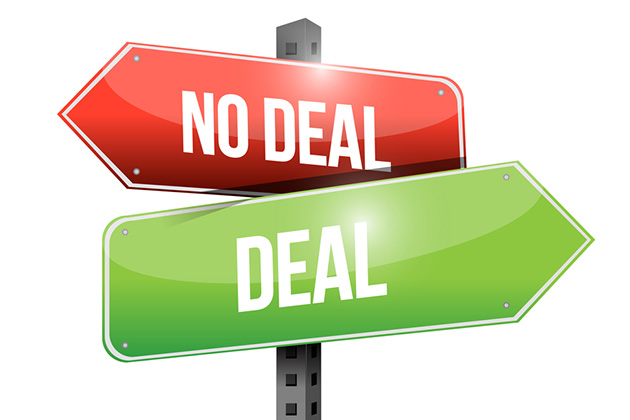

In [46]:
path_newer = 'C:\Inna\'s files\data\Cars\deal.jpg'
Image(filename = path_newer, width=400, height=200)

#  WHAT CAR BRANDS?

Now that we can be certain that we can get a deal, we could look into what car brands can we get a closer look at this subgroup. What brands can we get and what are their registation years?

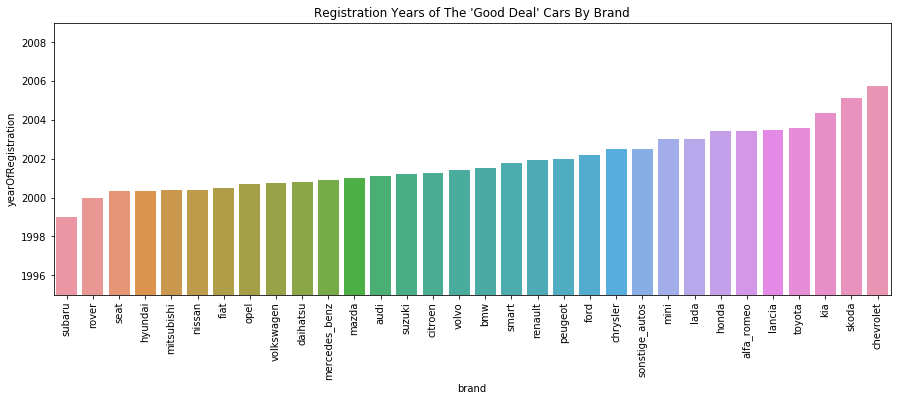

In [63]:
grouped_data = deal_old.groupby(['brand']).mean().reset_index()
grouped_one = grouped_data.sort_values(['yearOfRegistration']) 

plt.figure(figsize=(15,5))
sns.barplot(grouped_one['brand'], grouped_data['yearOfRegistration'])
plt.xticks(rotation=90)
plt.ylim([1995, 2009])
plt.title('Registration Years of The \'Good Deal\' Cars By Brand')
plt.show()


The graph above shows us car brands represented in our 'good deal' subgroup sorted by registration year. We can proceed to examine if the difference in car prices of the three brands with the earliest registration years (Subaru, Rover, and Seat) and those with the newest registratoin years (Chevrolet, Skoda, and Kia) is statistically significant. Our t-test returns a very small p-value, so we can conclude that this difference is indeed significant.

In [61]:
min_price = deal_old[deal_old['brand'].isin(grouped_one['brand'].iloc[:3])]
max_price = deal_old[deal_old['brand'].isin(grouped_one['brand'].iloc[-3:])]

print(ttest_ind(min_price['price'], max_price['price'], equal_var=False))
                                            

Ttest_indResult(statistic=-3.495045678231507, pvalue=0.0018957206475185447)


Finally, we could investigate our chances of getting a 'good deal' depending on the type of transmission.

Text(0,0.5,'Number of Cars')

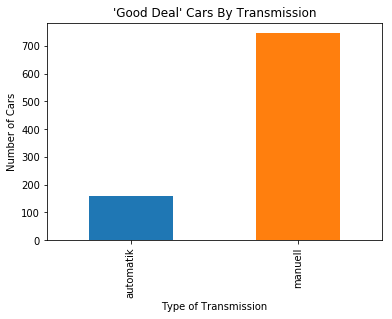

In [49]:
deal_old.groupby(['gearbox']).size().plot(kind='bar')
plt.title('\'Good Deal\' Cars By Transmission')
plt.xlabel('Type of Transmission')
plt.ylabel('Number of Cars')

It turns out that while it is not impossible to get a 'good deal' car with automatic transmission, our chances seem to be much higher if we go with **manual**.

#  CLOSING REMARKS

In this analysis, we were able to investigate the relationships between mileage, registration year, and car price. We were able to find a subgroup of affordable cars (from 1995 to 2009, with less than 5,000 kilometers under €7,500) that we called a 'good deal'. We were able to verify that this subgroup was indeed hotter on the market than average. Additionally, we gained a deeper understanding of the car brands distribution in our 'good deal' subgroup depending on the registration year.

It is worth mentioning that certain assumptions were made in this analysis. First, registration year was assumed to be indicative of car age. Second, number of days listed on *Ebay* was considered indicative of demand, whereas the last day on *Ebay* was equated with the day the car was sold. Additionally, the source of the data, i.e. web scraping, led to a certain degree of unreliability which we tried to accomodate to the best of our ability through data cleaning.

# FUTURE RESEARCH

A number of questions arose during the analysis that could be interesting to investigate in the future. They include:
- How the likelihood of getting a 'good deal' varies among different zipcodes in Germany?
- How do pictures affect purchasing behavior? In the current study, we did not have these data because of the bug in the web crawler.
- Is there any particular vocabulary and phrasing that could make an ad more successful?

Additionally, it would be intersting to build a similar web crawler for the US *Craigslist* (which is used more frequently for private car sales in the US than *Ebay*). This would allow us to compare the purchasing patterns between the two countries: Germany and the US. Are the identified patterns different in the US? With longer distances in the US, we could hypothesize that used cars would have much higher mileage. How would that affect the price?

Finally, we could build an identifier of low outliers in terms of price that could present a business opportunity for a business or an individual. 